In [61]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [62]:
air_passengers = pd.read_csv('/root/Documents/TradingReal/RwandaFinanceData/RwandeseFranc4.csv')

In [63]:
air_passengers['Years']= pd.to_datetime(air_passengers['Years'])

In [64]:
air_passengers.set_index('Years', inplace=True)

In [65]:
air_passengers['Price']=air_passengers['Price'].replace([5.782500], 578.2500)

In [66]:
log_air_passengers = np.log(air_passengers.Price)
log_air_passengers[1:10]

Years
2004-01-02    6.301464
2004-01-05    6.301574
2004-01-06    6.300731
2004-01-07    6.301208
2004-01-08    6.299666
2004-01-09    6.303772
2004-01-12    6.303370
2004-01-13    6.301409
2004-01-14    6.301318
Name: Price, dtype: float64

In [67]:
log_air_passengers_diff = log_air_passengers - log_air_passengers.shift()

In [68]:
log_air_passengers_diff.dropna(inplace=True)
log_air_passengers_diff[1:10]

Years
2004-01-05    0.000110
2004-01-06   -0.000844
2004-01-07    0.000477
2004-01-08   -0.001542
2004-01-09    0.004106
2004-01-12   -0.000403
2004-01-13   -0.001960
2004-01-14   -0.000092
2004-01-15   -0.000037
Name: Price, dtype: float64

In [69]:
# Let's talk about the ARIMA model
# Auto-Regressive Integrated Moving Average
# In this case we're talking about a series with dependence among values (more natural)

In [70]:
# Nothing but a linear regression with a few times
# 1. The number of Auto-Regressive Terms (p)
# 2. The number of Moving Average Terms (q)
# 3. The number of differences taken

In [71]:
# We don't pull these out of thin air, but rather draw them from the data
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(log_air_passengers_diff.values, nlags = 20)
lag_pacf = pacf(log_air_passengers_diff.values, nlags = 20)

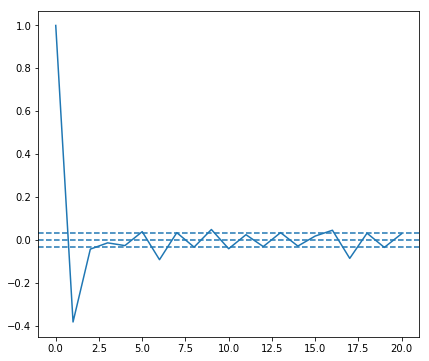

In [72]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')

In [73]:
# look at where the plot crosses the upper confidence interval for the first time
# for ACF this is 2 and gives us the p value

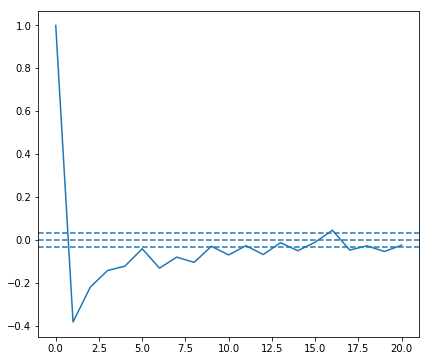

In [74]:
plt.subplot(121) 
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')

In [75]:
# look at where the plot crosses the upper confidence interval for the first time
# for PACF this is 2 and gives us the p value

In [76]:
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


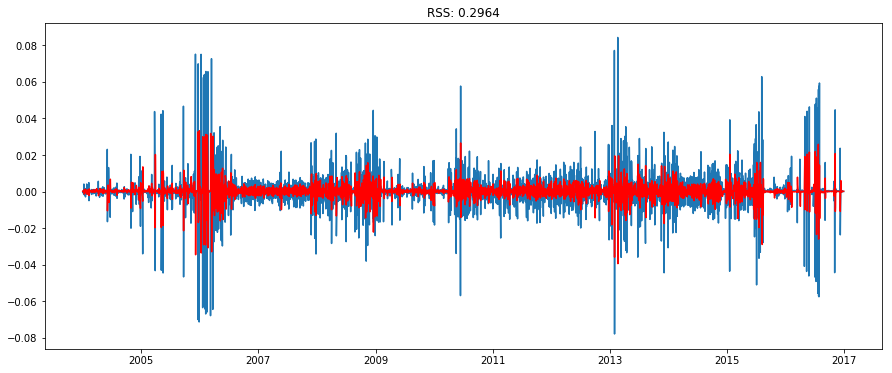

In [77]:
# AR model
model = ARIMA(log_air_passengers, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-log_air_passengers_diff)**2))

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


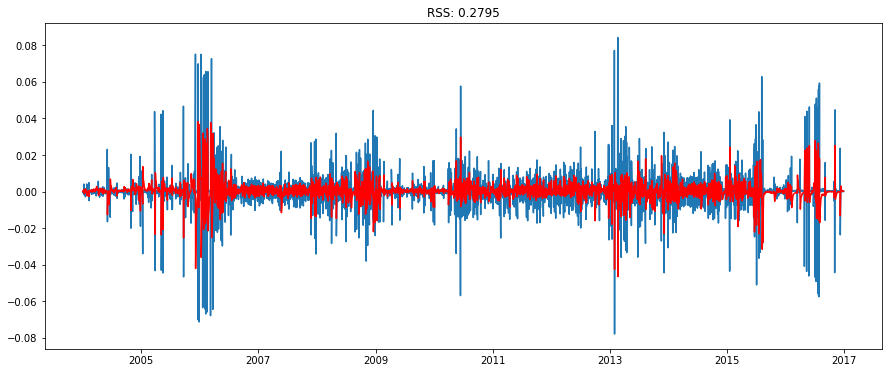

In [78]:
# MA model
model = ARIMA(log_air_passengers, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-log_air_passengers_diff)**2))

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


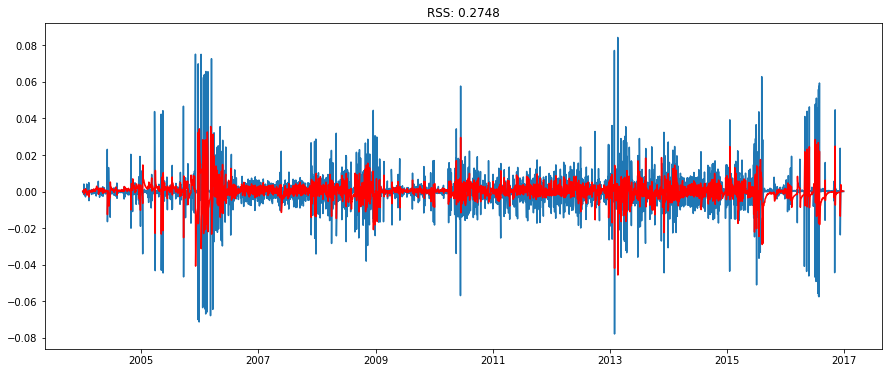

In [79]:
# ARIMA model
model = ARIMA(log_air_passengers, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_air_passengers_diff)**2))

In [80]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Years
2004-01-02    0.000117
2004-01-05    0.000162
2004-01-06    0.000145
2004-01-07    0.000611
2004-01-08    0.000248
dtype: float64


In [81]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Years
2004-01-02    0.000117
2004-01-05    0.000279
2004-01-06    0.000425
2004-01-07    0.001036
2004-01-08    0.001284
dtype: float64


In [82]:
predictions_ARIMA_log = pd.Series(log_air_passengers.ix[0], index=log_air_passengers.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Years
2004-01-01    6.301464
2004-01-02    6.301582
2004-01-05    6.301744
2004-01-06    6.301889
2004-01-07    6.302500
dtype: float64

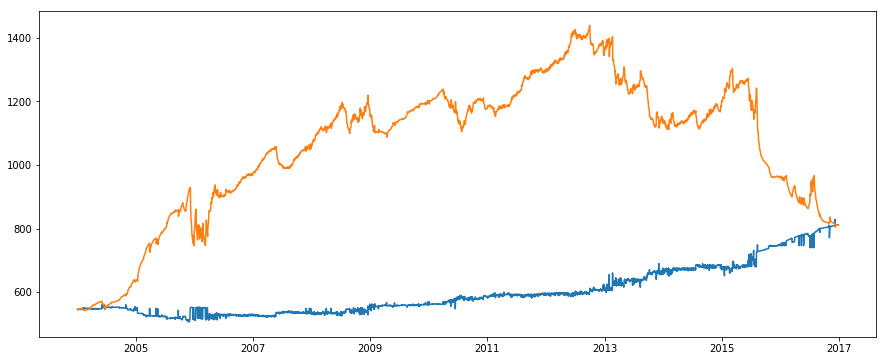

In [83]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(air_passengers)
plt.plot(predictions_ARIMA)

In [84]:
predictions_ARIMA.head()

Years
2004-01-01    545.370000
2004-01-02    545.433961
2004-01-05    545.522356
2004-01-06    545.601687
2004-01-07    545.935116
dtype: float64

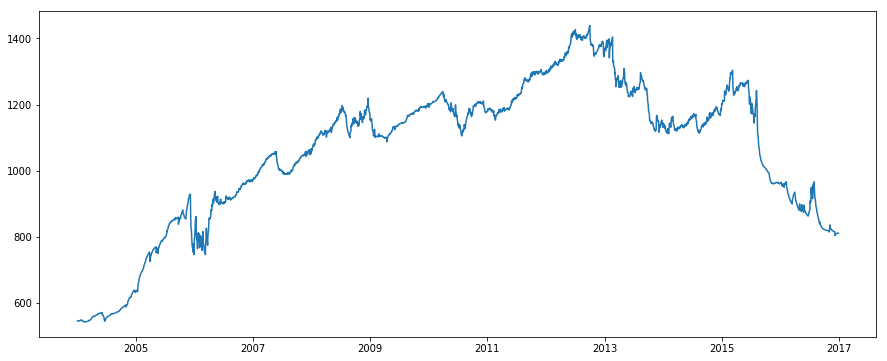

In [86]:
plt.plot(predictions_ARIMA)